In [134]:
import os
import math

import matplotlib
import numpy as np
import sys
import scipy
import yaml

from sklearn.metrics import mean_squared_error

sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from matplotlib import cm

from slow_reservoir.model import RNN, RNNSimple
from slow_reservoir.dataset.dynamic_state import State

%matplotlib inline

In [135]:
freq = []
for i in range(100):
    for j in range(np.random.randint(5)):
            freq.append(0)
    for j in range(np.random.randint(5)):
            freq.append(1)

In [136]:
def make_signal(N, time_length, state_list, uncertainty=0.5, interval=30):
    input_signals = np.zeros([N, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    sigma_sq = 0.5
    g = .5
    target_list = np.zeros([N, 400])
    signal_mu_list = np.zeros((N, time_length))
    true_signal_list = np.zeros((N, time_length))
    
    for i in range(N):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            if (t // interval) % 2:
                true_signal = state_list[0]()
            else:
                true_signal = state_list[1]()
            # true_signal = state_list[freq[t]]()
            true_signal_list[i, t] = true_signal
            
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            signal_mu_list[i, t] = signal_mu
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        
    return input_signals, true_signal_list, signal_mu_list

In [137]:
def calc_bayesian_optimal(mu_l, sigma_l, mu_p, sigma_p):
    return mu_p * (sigma_l**2/(sigma_p**2+sigma_l**2)) + mu_l * (sigma_p**2/(sigma_p**2+sigma_l**2))

In [138]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220528_all_slow/20220528_all_slow.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model_1 = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
    # sigma_neu=0,
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model_1.load_state_dict(torch.load(model_path, map_location=device))
model_1.eval()



model_name:  20220528_all_slow


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [139]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220528_4/20220528_4.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    
model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model_4 = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
    # sigma_neu=0,
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model_4.load_state_dict(torch.load(model_path, map_location=device))
model_4.eval()



model_name:  20220528_4


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [158]:
state_list = [
    State(mu=-0.5, sigma=0.5),
    State(mu=0.5, sigma=0.5),
]

In [159]:
sample_num = 500
time_length = 120
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=time_length, 
    uncertainty=0.5,
    interval=30,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_1, prior_list, reservoir_list = model_1(inputs, hidden, reservoir, time_length)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_4, prior_list, reservoir_list = model_4(inputs, hidden, reservoir, time_length)                                                          



In [160]:
sigma_l = math.sqrt(1/.5) * 0.5
bayesian_optimal_a = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[0].mu, state_list[0].sigma,
)
bayesian_optimal_b = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[1].mu, state_list[1].sigma,
)

In [161]:
norm =  bayesian_optimal_b - bayesian_optimal_a

for i in range(sample_num):
    for j in range(time_length):
        if abs(norm[i, j]) < 0.01:
            if norm[i, j] < 0:
                norm[i, j] = -0.01
            else:
                norm[i, j] = 0.01

alpha_samples_1 = (bayesian_optimal_b - np.array(outputs_1[:, :, 0].tolist())) / norm
alpha_samples_4 = (bayesian_optimal_b - np.array(outputs_4[:, :, 0].tolist())) / norm

alpha_1 = np.mean(alpha_samples_1, axis=0)
alpha_4 = np.mean(alpha_samples_4, axis=0)

alpha_1_std = np.std(alpha_samples_1, axis=0)
alpha_4_std = np.std(alpha_samples_4, axis=0)

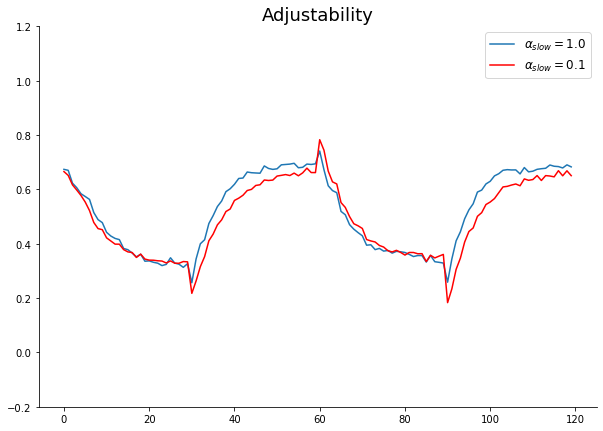

In [162]:
plt.figure(figsize=(10, 7))

plt.plot(alpha_1, label=r'$\alpha_{slow}=1.0$')
# plt.fill_between(range(time_length), alpha_1-alpha_1_std, alpha_1+alpha_1_std, alpha=.1)
plt.plot(alpha_4, label=r'$\alpha_{slow}=0.1$', color='red')
# plt.fill_between(range(time_length), alpha_4-alpha_4_std, alpha_4+alpha_4_std, alpha=.1)
plt.ylim([-0.2, 1.2])

plt.legend(fontsize=12)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.title('Adjustability', fontsize=18)
# plt.savefig('results/20220524/adjustability_5.png')
plt.show()

In [145]:
#### sample_num = 500
time_length = 120
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=time_length, 
    uncertainty=0.5,
    interval=5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_1, prior_list, reservoir_list = model_1(inputs, hidden, reservoir, time_length)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_4, prior_list, reservoir_list = model_4(inputs, hidden, reservoir, time_length)                                                          



In [146]:
sigma_l = math.sqrt(1/.5) * 0.5
bayesian_optimal_a = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[0].mu, state_list[0].sigma,
)
bayesian_optimal_b = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[1].mu, state_list[1].sigma,
)

In [147]:
norm =  bayesian_optimal_b - bayesian_optimal_a

for i in range(sample_num):
    for j in range(time_length):
        if abs(norm[i, j]) < 0.01:
            if norm[i, j] < 0:
                norm[i, j] = -0.01
            else:
                norm[i, j] = 0.01

alpha_samples_1 = (bayesian_optimal_b - np.array(outputs_1[:, :, 0].tolist())) / norm
alpha_samples_4 = (bayesian_optimal_b - np.array(outputs_4[:, :, 0].tolist())) / norm

alpha_1 = np.mean(alpha_samples_1, axis=0)
alpha_4 = np.mean(alpha_samples_4, axis=0)

alpha_1_std = np.std(alpha_samples_1, axis=0)
alpha_4_std = np.std(alpha_samples_4, axis=0)

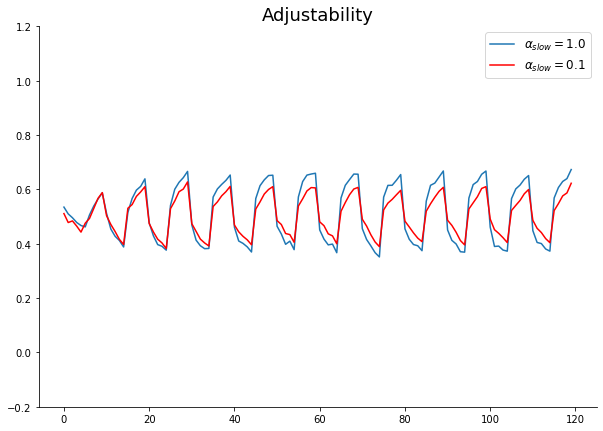

In [148]:
plt.figure(figsize=(10, 7))

plt.plot(alpha_1, label=r'$\alpha_{slow}=1.0$')
# plt.fill_between(range(time_length), alpha_1-alpha_1_std, alpha_1+alpha_1_std, alpha=.1)
plt.plot(alpha_4, label=r'$\alpha_{slow}=0.1$', color='red')
# plt.fill_between(range(time_length), alpha_4-alpha_4_std, alpha_4+alpha_4_std, alpha=.1)
plt.ylim([-0.2, 1.2])

plt.legend(fontsize=12)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.title('Adjustability', fontsize=18)
# plt.savefig('results/20220524/adjustability_6.png')
plt.show()

In [149]:
state_list = [
    State(mu=0.5, sigma=0.1),
    State(mu=-0.5, sigma=0.1),
]

sample_num = 500
time_length = 120
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=time_length, 
    uncertainty=0.5,
    interval=60,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_1, prior_list, reservoir_list = model_1(inputs, hidden, reservoir, time_length)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_4, prior_list, reservoir_list = model_4(inputs, hidden, reservoir, time_length)                                                          

sigma_l = math.sqrt(1/.5) * 0.5
bayesian_optimal_a = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[0].mu, state_list[0].sigma,
)
bayesian_optimal_b = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[1].mu, state_list[1].sigma,
)




In [150]:
norm =  bayesian_optimal_b - bayesian_optimal_a

for i in range(sample_num):
    for j in range(time_length):
        if abs(norm[i, j]) < 0.01:
            if norm[i, j] < 0:
                norm[i, j] = -0.01
            else:
                norm[i, j] = 0.01

alpha_samples_1 = (bayesian_optimal_b - np.array(outputs_1[:, :, 0].tolist())) / norm
alpha_samples_4 = (bayesian_optimal_b - np.array(outputs_4[:, :, 0].tolist())) / norm

alpha_1 = np.mean(alpha_samples_1, axis=0)
alpha_4 = np.mean(alpha_samples_4, axis=0)



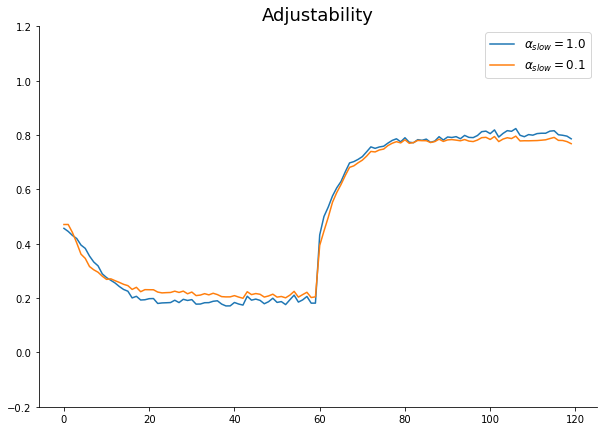

In [151]:
plt.figure(figsize=(10, 7))

plt.plot(alpha_1, label=r'$\alpha_{slow}=1.0$')
plt.plot(alpha_4, label=r'$\alpha_{slow}=0.1$')
plt.ylim([-0.2, 1.2])

plt.legend(fontsize=12)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.title('Adjustability', fontsize=18)
plt.show()

In [152]:
state_list = [
    State(mu=0.1, sigma=0.5),
    State(mu=-0.1, sigma=0.5),
]

sample_num = 500
time_length = 120
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=time_length, 
    uncertainty=0.5,
    interval=60,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_1, prior_list, reservoir_list = model_1(inputs, hidden, reservoir, time_length)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_4, prior_list, reservoir_list = model_4(inputs, hidden, reservoir, time_length)                                                          

sigma_l = math.sqrt(1/.5) * 0.5
bayesian_optimal_a = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[0].mu, state_list[0].sigma,
)
bayesian_optimal_b = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[1].mu, state_list[1].sigma,
)




In [153]:
norm =  bayesian_optimal_b - bayesian_optimal_a

for i in range(sample_num):
    for j in range(time_length):
        if abs(norm[i, j]) < 0.01:
            if norm[i, j] < 0:
                norm[i, j] = -0.01
            else:
                norm[i, j] = 0.01

alpha_samples_1 = (bayesian_optimal_b - np.array(outputs_1[:, :, 0].tolist())) / norm
alpha_samples_4 = (bayesian_optimal_b - np.array(outputs_4[:, :, 0].tolist())) / norm

alpha_1 = np.mean(alpha_samples_1, axis=0)
alpha_4 = np.mean(alpha_samples_4, axis=0)



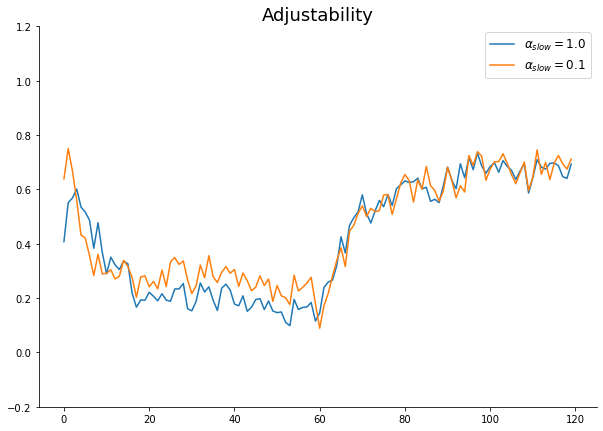

In [154]:
plt.figure(figsize=(10, 7))

plt.plot(alpha_1, label=r'$\alpha_{slow}=1.0$')
plt.plot(alpha_4, label=r'$\alpha_{slow}=0.1$')
plt.ylim([-0.2, 1.2])

plt.legend(fontsize=12)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.title('Adjustability', fontsize=18)
plt.show()

In [155]:
state_list = [
    State(mu=0.4, sigma=0.3),
    State(mu=-0.4, sigma=0.3),
]

sample_num = 500
time_length = 120
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=time_length, 
    uncertainty=0.5,
    interval=60,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_1, prior_list, reservoir_list = model_1(inputs, hidden, reservoir, time_length)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_4, prior_list, reservoir_list = model_4(inputs, hidden, reservoir, time_length)                                                          

sigma_l = math.sqrt(1/.5) * 0.5
bayesian_optimal_a = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[0].mu, state_list[0].sigma,
)
bayesian_optimal_b = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[1].mu, state_list[1].sigma,
)




In [156]:
norm =  bayesian_optimal_b - bayesian_optimal_a

for i in range(sample_num):
    for j in range(time_length):
        if abs(norm[i, j]) < 0.01:
            if norm[i, j] < 0:
                norm[i, j] = -0.01
            else:
                norm[i, j] = 0.01

alpha_samples_1 = (bayesian_optimal_b - np.array(outputs_1[:, :, 0].tolist())) / norm
alpha_samples_4 = (bayesian_optimal_b - np.array(outputs_4[:, :, 0].tolist())) / norm

alpha_1 = np.mean(alpha_samples_1, axis=0)
alpha_4 = np.mean(alpha_samples_4, axis=0)



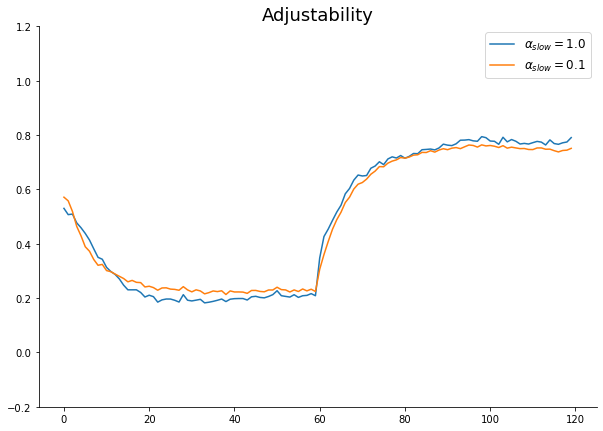

In [157]:
plt.figure(figsize=(10, 7))

plt.plot(alpha_1[:], label=r'$\alpha_{slow}=1.0$')
plt.plot(alpha_4[:], label=r'$\alpha_{slow}=0.1$')
plt.ylim([-0.2, 1.2])

plt.legend(fontsize=12)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.title('Adjustability', fontsize=18)
plt.show()